**Problem Statement:**  
In healthcare, patient engagement is an essential part for both providers and patients to work together to improve health. During the entire decision-making process based on a patient's health conditions, the more the patient remains engaged in the process, the much more reliable decisions can be made according to patient's data been recorded during this process. Besides, patients who are actively keeping themselves engaged in the process tend to be healthier and lead to better health outcomes compared to those who are not.

With the application of today's AI/ML techniques, we are able to enhance patient engagement solutions and care management services. Some popular parts include:  
1. Understand patient behaviour
2. Respond to patients in a timely manner
3. Personalized and intelligent decisions for patients

In this notebook, I'm going to dig into analyze patient's engagement rate and predict future response rate based on patient's historical data. Note that the data is coming from my employer and this is a ML project that I'm currently working on.

The <font color="red">**goal**</font> is to ***identify risky patients who intend to be dropping off after 2 months engagement to the company's remote health monitoring system.*** With ML approaches, the company can have a clear view of what the underlying probability is like and what potential factors are for patients who will drop off, then those predicted drop-off patients will be reached out by PES team to prevent dropping off.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import shap
from datetime import datetime, date, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report, mean_squared_error, make_scorer, r2_score, roc_curve
from skopt import BayesSearchCV

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import plotly.graph_objects as go

pd.set_option('display.max_columns', None) 
# pd.set_option('display.max_rows', None)

#### Data preprocessing:

First, let's have an overview on the entire data. The size of the dataset is not too large, it contains 8356 rows/patients and 48 columns/features including numerical target column "2m1w_rr" - patient's response rate at the week after the first 2 month of engagement in the system.  
This part includes:
- Data Cleaning
- Outlier Detection
- Feature Engineering (deal with missing values; create new features; create dummy variables(OHE))
- Dimension Reduction (PCA)

In [2]:
# Load data:
df = pd.read_csv('/Users/dan/Code/Interventions/backups/intervention3-2_backup/all6_32.csv')

In [3]:
df

patientId         dob start_date   end_date  time_length_d  \
0          1739   2/25/1938  2/25/2016   5/9/2019           1169   
1          1775         NaN  2/24/2016  9/29/2017            583   
2          1781    7/5/1929  4/18/2018  6/22/2018             65   
3          1797   12/9/1934  2/24/2016   1/4/2018            680   
4          1801   3/23/1944  2/27/2016   1/1/2200           1437   
...         ...         ...        ...        ...            ...   
8351      40666   6/30/1957   2/1/2020   1/1/2200              2   
8352      40667  11/27/1933   2/2/2020   1/1/2200              1   
8353      40668   5/19/1950   2/2/2020   1/1/2200              1   
8354      40669    6/7/1939   2/2/2020   1/1/2200              1   
8355      40670   1/12/1922   2/3/2020   1/1/2200              0   

     intervention_name  types  calls  messages  avg_rate  avg_communication  \
0              epxcopd      1      4         0       9.0                9.0   
1           epxdepress      1      0         4       5.0                5.0   
2              epxcopd      1      4         0       6.0                3.5   
3             epxhyper      1      5         0       0.0                0.0   
4          epxdiabetes      1      4         0       0.0                0.0   
...                ...    ...    ...       ...       ...                ...   
8351          epxheart      1      0         1       0.0                0.0   
8352          epxheart      1      1         0       0.0                0.0   
8353       epxdiabetes      1      0         1       0.0                0.0   
8354           epxcopd      1      1         0       0.0                0.0   
8355          epxheart      1      0         1       0.0                0.0   

      avg_frequency  no_rate  no_communication  no_frequency  1_14_rr  \
0               5.0        0                 0             0   0.8571   
1               5.0        0                 0             0   0.5000   
2               1.5        0                 0             0   1.0000   
3               0.0        1                 1             1   0.3333   
4               0.0        1                 1             1   0.9333   
...             ...      ...               ...           ...      ...   
8351            0.0        1                 1             1   0.6667   
8352            0.0        1                 1             1   0.5000   
8353            0.0        1                 1             1   0.5000   
8354            0.0        1                 1             1   1.0000   
8355            0.0        1                 1             1   1.0000   

      1_14_sc  1_14_rc  1_14_avg_respond_duration_s  \
0          14       12                      50.6667   
1          14        7                   14808.8571   
2           6        6                     367.6667   
3           3        1                      63.0000   
4          15       14                     691.1429   
...       ...      ...                          ...   
8351        3        2                    1280.0000   
8352        2        1                     670.0000   
8353        2        1                      71.0000   
8354        1        1                     289.0000   
8355        1        1                    7163.0000   

      1_14_respond_inAdvance_count  1_14_alert_count  1_14_isRead_count  \
0                                0                 2                1.0   
1                                0                 1                1.0   
2                                0                 1                0.0   
3                                0                 0                NaN   
4                                0                 1                1.0   
...                            ...               ...                ...   
8351                             0                 0                NaN   
8352                             0                 1                0.0   
8353                       

#### Data Cleaning & Feature Engineering I:

Here, I summarize the feature categories from a high level: [feature explaination]  

***Predictors:***
1. Date of birth - age
2. Time length by day - how many days that the patients is on the system since the start date.
3. Intervention name - there are 6 interventions, COPD, asthma, Diabetes, Depression, Hypertension, Heart Failure.

[4-12. types, calls, messages, avg_rate, avg_communication, avg_frequency, no_rate, no_communication, no_frequency, those features are related to the Survey Qualities in the database.]
4. types - there are two types of communications to receive feedbacks from patients, either by calls or text messages, or both of them. 1 means the patient only uses calls or text messages, 2 means the patient receives/gives back feedbacks by both calls and text messages.
5. calls - among all received feedbacks from calls or text messages or both of them, how many times are by calls? If we sum over calls column and messages column, then we get the total number of feedbacks that patient has received, so this also provides info about patient's review regarding the system and the backend providers/doctors who are using the system to give care for the patient.
6. messages - among all received feedbacks from calls or text messages or both of them, how many times are by text messages?
7. avg_rate - among all ratings patient has given (on a scale of 1-9), calculate the averaged rating.
8. avg_communication - among all rating scores given by patients regarding the communication with their providers/doctors (on a scale of 1-9), calculate the averated communication scores.
9. avg_frequency - among all rating scores given by patients regarding the communicate frequency that their providers/doctors (on a scale of 1-9) have, calculate the averated frequency scores.

[the rest of features are all about same information in 0-2 week;2-4 week;4-6 week;6-8 week time window]  
10. 1-14 days info, 0-2 week itme window:  
    - 1_14_rr - response rate  
    - 1_14_rc - respond count, how many sessions have been responded by the patient  
    - 1_14_sc - session count, how many sessions the patient has during the first 2 weeks  
    - 1_14_avg_respond_duration_s - calculate the duration or say time difference between call/message time and patient's respond time by seconds, then record the averaged time diff.  
    - 1_14_respond_inAdvance_count - for Diabetes, patient can respond that text message before the regular time that the message is sent during the day time, this feature records: 1, patient does respond before the fixed setup time; 0, respond after the setup call/message time; -1, if there is a response earlier than the setup time in interventions other than Diabetes, then this is an error and is recorded as -1.  
    - 1_14_alert_count - how many alerts patient has triggered, this is based on different medical standards in each intervention.  
    - 1_14_isRead_count - whether the alerts have been read by the providers/doctors. 1 means it is read, 0 means it has not been read.  
    - 1_14_avg_alert_duration_d - the averaged time duration or say time difference by day between alerts-created time and alerts-read time.  
    - 1_14_zeroDuration - explaination is provided in the following part.
11. 15-28 days info, 2-4 week time window:  
    - Same as above
12. 29-42 days info, 4-6 week time window:  
    - Same as above
13. 43-56 days info, 6-8 week time window:  
    - Same as above  

***Target (numerical):***  
2m1w_rr, which stands for the response rate at the first week right after 2 month engagement.  

***Target, to-be-added and used in the final prediction (categorical):***  
2month1week_engagement, which stands for whether the patient has a response rate larger than 0.3 af at the first week right after 2 month engagement.

In [4]:
# Calculate age and create two other age related columns - age_range & age_null:
today = pd.to_datetime(['03/02/2020']*len(df), format='%m/%d/%Y')
df["dob"] = df.dob.apply(lambda x: '03/02/2020' if(type(x)==float) else x)
dob = df.dob.apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
age = (today - dob)/365.25
age = age.apply(lambda x: x.days)
df["age"] = age
df["age_range"] = df.age.apply(lambda x: 0 if x<=18 else 1 if (x>18) & (x<=45) else 2 if (x>45) & (x<=65) else 3 if (x>65) & (x<=75) else 4)
df["age_null"] = df.age_range.apply(lambda x: 1 if(x==0) else 0)
df.drop(labels=["age"], axis=1, inplace=True)

For those rows without age info, 0 will be used instead. A new numerical column "age_range" is created to represent the range of ages:  
    - 0 - 0 < age <= 18  
    - 1 - 18 < age <= 45  
    - 2 - 45 < age <= 65  
    - 3 - 65 < age <= 75  
    - 4 - age > 75  
Another new created column "age_null" refers to whether age column contains no information, 1 means no age in original age column, 0 means there is an age value. The <font color="red">**reason**</font> for doing this is that I don't want to impute missing values, I would like to remain the dataset as original as it can be.

In [5]:
# Rearrange the order of columns:
# First, get a list of columns
cols = list(df)
# Second, move column age_range and age_null towards the head of list using index, pop and insert
cols.insert(4, cols.pop(cols.index("age_range")))
cols.insert(5, cols.pop(cols.index("age_null")))
# Third, use loc to reorder
df = df.loc[:, cols]

# Drop useless columns:
df.drop(labels=["patientId","dob","start_date","end_date"], axis=1, inplace=True)

In [6]:
df

age_range  age_null  time_length_d intervention_name  types  calls  \
0             4         0           1169           epxcopd      1      4   
1             0         1            583        epxdepress      1      0   
2             4         0             65           epxcopd      1      4   
3             4         0            680          epxhyper      1      5   
4             3         0           1437       epxdiabetes      1      4   
...         ...       ...            ...               ...    ...    ...   
8351          2         0              2          epxheart      1      0   
8352          4         0              1          epxheart      1      1   
8353          3         0              1       epxdiabetes      1      0   
8354          4         0              1           epxcopd      1      1   
8355          4         0              0          epxheart      1      0   

      messages  avg_rate  avg_communication  avg_frequency  no_rate  \
0            0       9.0                9.0            5.0        0   
1            4       5.0                5.0            5.0        0   
2            0       6.0                3.5            1.5        0   
3            0       0.0                0.0            0.0        1   
4            0       0.0                0.0            0.0        1   
...        ...       ...                ...            ...      ...   
8351         1       0.0                0.0            0.0        1   
8352         0       0.0                0.0            0.0        1   
8353         1       0.0                0.0            0.0        1   
8354         0       0.0                0.0            0.0        1   
8355         1       0.0                0.0            0.0        1   

      no_communication  no_frequency  1_14_rr  1_14_sc  1_14_rc  \
0                    0             0   0.8571       14       12   
1                    0             0   0.5000       14        7   
2                    0             0   1.0000        6        6   
3                    1             1   0.3333        3        1   
4                    1             1   0.9333       15       14   
...                ...           ...      ...      ...      ...   
8351                 1             1   0.6667        3        2   
8352                 1             1   0.5000        2        1   
8353                 1             1   0.5000        2        1   
8354                 1             1   1.0000        1        1   
8355                 1             1   1.0000        1        1   

      1_14_avg_respond_duration_s  1_14_respond_inAdvance_count  \
0                         50.6667                             0   
1                      14808.8571                             0   
2                        367.6667                             0   
3                         63.0000                             0   
4                        691.1429                             0   
...                           ...                           ...   
8351                    1280.0000                             0   
8352                     670.0000                             0   
8353                      71.0000                             0   
8354                     289.0000                             0   
8355                    7163.0000                             0   

      1_14_alert_count  1_14_isRead_count  1_14_avg_alert_duration_d  \
0                    2                1.0                        0.0   
1                    1                1.0                        0.0   
2                    1                0.0                        NaN   
3                    0                NaN                        NaN   
4                    1                1.0                        0.0   
...                ...                ...                        ...   
8351                 0                NaN                        NaN   
8352                 1                0.0             

In [7]:
# Eliminate rows if 2m1w_rr equals to 0:
df2 = df[df["2m1w_rr"]>=0]

Here, 4 other new feature columns are created in reference to details about respond duration feature. Some patients may have the exact same response time with the pre-set call/message time, in this case the duration column would have a 0 value. However, patients who do not respond also have a 0 duration value. Therefore, "zeroDuration" feature is created to distinguish the difference between the two situations.

In [8]:
# Create 4 other new columns related to the respond duration feature:
df2["1_14_zeroDuration"] = df2["1_14_avg_respond_duration_s"].apply(lambda x: 1 if(math.isnan(x)) else 0)
df2["15_28_zeroDuration"] = df2["15_28_avg_respond_duration_s"].apply(lambda x: 1 if(math.isnan(x)) else 0)
df2["29_42_zeroDuration"] = df2["29_42_avg_respond_duration_s"].apply(lambda x: 1 if(math.isnan(x)) else 0)
df2["43_56_zeroDuration"] = df2["43_56_avg_respond_duration_s"].apply(lambda x: 1 if(math.isnan(x)) else 0)

Although the target column is numerical, goal of this project is to identify patients with response rates lower than 0.3. Thus, this is more like a classification problem, so a new categorical column is created in the following.

In [9]:
# Create categorical target column:
label_categorical = list(df2["2m1w_rr"])
label_binary = [0 if(item>0.3) else 1 for item in list(df2["2m1w_rr"])]
df2.drop(labels=["2m1w_rr"], axis=1, inplace=True)
df2["2m1w_rr"] = label_categorical
df2["2month1week_engagement"] = label_binary

In [10]:
df2

age_range  age_null  time_length_d intervention_name  types  calls  \
0             4         0           1169           epxcopd      1      4   
1             0         1            583        epxdepress      1      0   
2             4         0             65           epxcopd      1      4   
3             4         0            680          epxhyper      1      5   
4             3         0           1437       epxdiabetes      1      4   
...         ...       ...            ...               ...    ...    ...   
7103          2         0             55       epxdiabetes      1      0   
7110          2         0             55       epxdiabetes      1      0   
7111          2         0             55       epxdiabetes      1      0   
7114          2         0             55       epxdiabetes      1      0   
7120          3         0             55          epxhyper      1      0   

      messages  avg_rate  avg_communication  avg_frequency  no_rate  \
0            0       9.0                9.0            5.0        0   
1            4       5.0                5.0            5.0        0   
2            0       6.0                3.5            1.5        0   
3            0       0.0                0.0            0.0        1   
4            0       0.0                0.0            0.0        1   
...        ...       ...                ...            ...      ...   
7103         3       0.0                0.0            0.0        1   
7110         3       0.0                0.0            0.0        1   
7111         3       8.0                9.0            0.0        0   
7114         3       0.0                0.0            0.0        1   
7120         3       0.0                0.0            0.0        1   

      no_communication  no_frequency  1_14_rr  1_14_sc  1_14_rc  \
0                    0             0   0.8571       14       12   
1                    0             0   0.5000       14        7   
2                    0             0   1.0000        6        6   
3                    1             1   0.3333        3        1   
4                    1             1   0.9333       15       14   
...                ...           ...      ...      ...      ...   
7103                 1             1   0.8333        6        5   
7110                 1             1   0.0000        5        0   
7111                 0             1   1.0000        5        5   
7114                 1             1   0.1429        7        1   
7120                 1             1   0.4000        5        2   

      1_14_avg_respond_duration_s  1_14_respond_inAdvance_count  \
0                         50.6667                             0   
1                      14808.8571                             0   
2                        367.6667                             0   
3                         63.0000                             0   
4                        691.1429                             0   
...                           ...                           ...   
7103                    2839.4000                             0   
7110                          NaN                             0   
7111                     753.8000                             0   
7114                       0.0000                             0   
7120                    1559.0000                             0   

      1_14_alert_count  1_14_isRead_count  1_14_avg_alert_duration_d  \
0                    2                1.0                        0.0   
1                    1                1.0                        0.0   
2                    1                0.0                        NaN   
3                    0                NaN                        NaN   
4                    1                1.0                        0.0   
...                ...                ...                        ...   
7103                 0                NaN                        NaN   
7110                 0                NaN             

**Data Leakage (caused by missing data imputation):**   

Before filling the missing value NaN with 0, I want to discuss about imputation. The correct operation for imputing missing values is **First - train/test split; Second - do the imputation for missing data**, this is for prevention of **data leakage**. Take age column as an example, dataset is (1) split into train and test set, then (2) use the mean of training set, e.g. mean(train_age)=56, as the base value to fill all NaN in test set; what if mean(test_age)=50? we should again use mean(train_age)=56 to impute on test set since test set is smaller than training and it would cause bias if using 50 for imputation.  

However, here I do fill NA even before the train/test split since I'm going to impute ALL missing data with 0 anyways.

In [11]:
# Fill NaN values with value 0 on all columns:
df2.fillna(value=0, inplace=True)
df2.reset_index(inplace=True, drop=True)

In [12]:
# Check null values:
df2.isnull().any()==False

age_range                        True
age_null                         True
time_length_d                    True
intervention_name                True
types                            True
calls                            True
messages                         True
avg_rate                         True
avg_communication                True
avg_frequency                    True
no_rate                          True
no_communication                 True
no_frequency                     True
1_14_rr                          True
1_14_sc                          True
1_14_rc                          True
1_14_avg_respond_duration_s      True
1_14_respond_inAdvance_count     True
1_14_alert_count                 True
1_14_isRead_count                True
1_14_avg_alert_duration_d        True
15_28_rr                         True
15_28_sc                         True
15_28_rc                         True
15_28_avg_respond_duration_s     True
15_28_respond_inAdvance_count    True
15_28_alert_

In reality, there are some patients with totally zero engagement on the system and they are kind of people who have zero-always response rates in the 2 month period. For those of patients, I decide to drop them.

In [13]:
# Drop rows with 1_14_rr=0 / 15_28_rr=0 / 29_42_rr=0 / 43_56_rr=0:
df2.drop(df2[(df2["1_14_rr"]==0) & (df2["15_28_rr"]==0) & (df2["29_42_rr"]==0) & (df2["43_56_rr"]==0)].index, inplace=True)

# Reset index:
df2.reset_index(inplace=True, drop=True)

# Shape of the new dataframe:
print(df2.shape)

# Add newly created categorical target column onto the dataframe
# ONE encoding other categorical features
df22 = pd.get_dummies(df2.drop(labels=["2month1week_engagement","2m1w_rr"], axis=1, inplace=False))
df22["2m1w_rr"] = df2["2m1w_rr"]
df22["2month1week_engagement"] = df2["2month1week_engagement"]
df22

(6069, 51)


age_range  age_null  time_length_d  types  calls  messages  avg_rate  \
0             4         0           1169      1      4         0       9.0   
1             0         1            583      1      0         4       5.0   
2             4         0             65      1      4         0       6.0   
3             4         0            680      1      5         0       0.0   
4             3         0           1437      1      4         0       0.0   
...         ...       ...            ...    ...    ...       ...       ...   
6064          2         0             56      1      0         3       0.0   
6065          2         0             55      1      0         3       0.0   
6066          2         0             55      1      0         3       8.0   
6067          2         0             55      1      0         3       0.0   
6068          3         0             55      1      0         3       0.0   

      avg_communication  avg_frequency  no_rate  no_communication  \
0                   9.0            5.0        0                 0   
1                   5.0            5.0        0                 0   
2                   3.5            1.5        0                 0   
3                   0.0            0.0        1                 1   
4                   0.0            0.0        1                 1   
...                 ...            ...      ...               ...   
6064                0.0            0.0        1                 1   
6065                0.0            0.0        1                 1   
6066                9.0            0.0        0                 0   
6067                0.0            0.0        1                 1   
6068                0.0            0.0        1                 1   

      no_frequency  1_14_rr  1_14_sc  1_14_rc  1_14_avg_respond_duration_s  \
0                0   0.8571       14       12                      50.6667   
1                0   0.5000       14        7                   14808.8571   
2                0   1.0000        6        6                     367.6667   
3                1   0.3333        3        1                      63.0000   
4                1   0.9333       15       14                     691.1429   
...            ...      ...      ...      ...                          ...   
6064             1   0.6316       19       12                     779.3333   
6065             1   0.8333        6        5                    2839.4000   
6066             1   1.0000        5        5                     753.8000   
6067             1   0.1429        7        1                       0.0000   
6068             1   0.4000        5        2                    1559.0000   

      1_14_respond_inAdvance_count  1_14_alert_count  1_14_isRead_count  \
0                                0                 2                1.0   
1                                0                 1                1.0   
2                                0                 1                0.0   
3                                0                 0                0.0   
4                                0                 1                1.0   
...                            ...               ...                ...   
6064                             0                 0                0.0   
6065                             0                 0                0.0   
6066                             0                 0                0.0   
6067                             0                 0                0.0   
6068                             0                 0                0.0   

      1_14_avg_alert_duration_d  15_28_rr  15_28_sc  15_28_rc  \
0                           0.0    1.0000      14.0      14.0   
1                           0.0    0.6429      14.0       9.0   
2                           0.0    0.6667       6.0       4.0   
3                           0.0    0.1538      13.0       2.0   
4                           0.0    0.9286      14.0      13.0   
...         

#### Outlier Detection:

It is necessary to remove outliers before starting building models, here I use Isolation Forest as the baseline to find/remove outliers. After using Isolation Forest, original 54 features are reduced via PCA to 8 dimensions.

In [1]:
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.ensemble import IsolationForest

As we can see that there are 401 outliers in the original dataset.

In [20]:
clf = IsolationForest(contamination="auto", max_features=1.0, n_estimators=100, max_samples="auto", bootstrap=False, random_state=42, n_jobs=-1)
clf_detector = clf.fit(df22)
pred_clf = clf_detector.predict(df22)

df22["anomaly"] = pred_clf
outliers = df22.loc[df22['anomaly']==-1]
outliers_idxes = list(outliers.index)

df22.anomaly.value_counts()

 1    5668
-1     401
Name: anomaly, dtype: int64

After finding out those outliers, I draw a 3D plot and a 2D plot to view the results. And, standardized scaling is used before applying PCA.

In [21]:
pca = PCA(n_components=3, random_state=42)  # Reduce to k=3 dimensions
scaler = StandardScaler()
# Normalize the metrics
df22_norm = scaler.fit_transform(df22)
df22_reduce = pca.fit_transform(df22_norm)
df22_reduce = pd.DataFrame(data=df22_reduce, columns=["pca1","pca2","pca3"])
df22_reduce["anomaly"] = df22["anomaly"]

In [22]:
inlier_df = df22_reduce[df22_reduce["anomaly"]==1]
outlier_df = df22_reduce[df22_reduce["anomaly"]==-1]

trace_inlier = go.Scatter3d(x=inlier_df["pca1"], y=inlier_df["pca2"], z=inlier_df["pca3"], mode="markers", marker=dict(size=3, color="blue"), showlegend=True, name="inliers")
trace_outlier = go.Scatter3d(x=outlier_df["pca1"], y=outlier_df["pca2"], z=outlier_df["pca3"], mode="markers", marker=dict(size=3, color="red"), showlegend=True, name="outliers")

data = [trace_inlier, trace_outlier]
fig = go.Figure(data=data)
fig.update_layout(
    scene = dict(
        xaxis_title='PCA_1',
        yaxis_title='PCA_2',
        zaxis_title='PCA_3'
    ),
    width=960,
    margin=dict(r=20, b=10, l=10, t=10),
    paper_bgcolor="rgba(0,0,0,0)"
)
fig.show();

In [23]:
pca_2 = PCA(n_components=2, random_state=42)  # Reduce to k=2 dimensions
scaler = StandardScaler()
# Normalize the metrics
df22_norm_2 = scaler.fit_transform(df22.drop(labels=["anomaly"], axis=1, inplace=False))
df22_reduce_2 = pca_2.fit_transform(df22_norm_2)
df22_reduce_2 = pd.DataFrame(data=df22_reduce_2, columns=["pca1","pca2"])
df22_reduce_2["anomaly"] = df22["anomaly"]

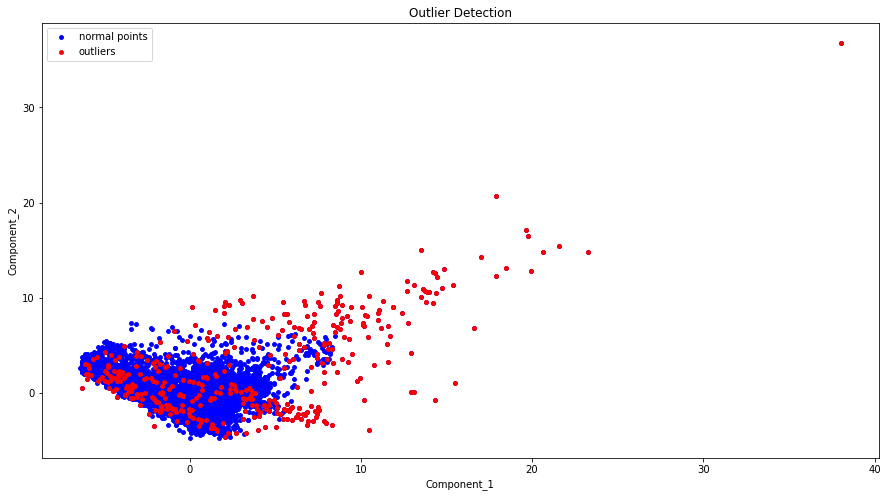

In [97]:
plt.figure(figsize=(15, 8))
plt.scatter(df22_reduce_2["pca1"], df22_reduce_2["pca2"], s=15, c="blue", label="normal points")
plt.scatter(df22_reduce_2.iloc[outliers_idxes, 0], df22_reduce_2.iloc[outliers_idxes, 1], s=15, c="red", label="outliers")
plt.legend(loc="best")
plt.title("Outlier Detection")
plt.xlabel("Component_1")
plt.ylabel("Component_2")
plt.savefig("outliers.png", dpi=300)
plt.show();

Then, those 401 outliers are removed from the dataset.

In [26]:
# Remove outlier rows:
df22 = df22[df22["anomaly"]!=-1]
df22.reset_index(drop=True, inplace=True)

In [27]:
df22

age_range  age_null  time_length_d  types  calls  messages  avg_rate  \
0             4         0           1169      1      4         0       9.0   
1             0         1            583      1      0         4       5.0   
2             4         0             65      1      4         0       6.0   
3             4         0            680      1      5         0       0.0   
4             3         0           1437      1      4         0       0.0   
...         ...       ...            ...    ...    ...       ...       ...   
5663          2         0             56      1      0         3       0.0   
5664          2         0             55      1      0         3       0.0   
5665          2         0             55      1      0         3       8.0   
5666          2         0             55      1      0         3       0.0   
5667          3         0             55      1      0         3       0.0   

      avg_communication  avg_frequency  no_rate  no_communication  \
0                   9.0            5.0        0                 0   
1                   5.0            5.0        0                 0   
2                   3.5            1.5        0                 0   
3                   0.0            0.0        1                 1   
4                   0.0            0.0        1                 1   
...                 ...            ...      ...               ...   
5663                0.0            0.0        1                 1   
5664                0.0            0.0        1                 1   
5665                9.0            0.0        0                 0   
5666                0.0            0.0        1                 1   
5667                0.0            0.0        1                 1   

      no_frequency  1_14_rr  1_14_sc  1_14_rc  1_14_avg_respond_duration_s  \
0                0   0.8571       14       12                      50.6667   
1                0   0.5000       14        7                   14808.8571   
2                0   1.0000        6        6                     367.6667   
3                1   0.3333        3        1                      63.0000   
4                1   0.9333       15       14                     691.1429   
...            ...      ...      ...      ...                          ...   
5663             1   0.6316       19       12                     779.3333   
5664             1   0.8333        6        5                    2839.4000   
5665             1   1.0000        5        5                     753.8000   
5666             1   0.1429        7        1                       0.0000   
5667             1   0.4000        5        2                    1559.0000   

      1_14_respond_inAdvance_count  1_14_alert_count  1_14_isRead_count  \
0                                0                 2                1.0   
1                                0                 1                1.0   
2                                0                 1                0.0   
3                                0                 0                0.0   
4                                0                 1                1.0   
...                            ...               ...                ...   
5663                             0                 0                0.0   
5664                             0                 0                0.0   
5665                             0                 0                0.0   
5666                             0                 0                0.0   
5667                             0                 0                0.0   

      1_14_avg_alert_duration_d  15_28_rr  15_28_sc  15_28_rc  \
0                           0.0    1.0000      14.0      14.0   
1                           0.0    0.6429      14.0       9.0   
2                           0.0    0.6667       6.0       4.0   
3                           0.0    0.1538      13.0       2.0   
4                           0.0    0.9286      14.0      13.0   
...         

#### Dataset Split:

For some reason, I would like to keep all 54 features and reduce to just 8 dimensions, and I know that doing PCA will lose the opportunity to understand the importance of original 54 features. However, I'm going to use feature importance on 8 newly created dimensions and then use PCA components to indirectly explore feature importance.

Since I will use sklearn's pipeline function to train/valid/test the model, therefore I will split the dataset first then do the normalization/PCA in pipelines. The dataset is sort of imbalanced so I used stratified dataset split here to make sure that the sample distributions are the same in both train and test set. And, the test_size setup is 0.36 which is finalized via trying multiple values to build a simple model first and see the optimal model preformance (both accuracy and AUC score).

In [28]:
X = df22.drop(labels=[
    "2m1w_rr",
    "2month1week_engagement",
    "anomaly"
], axis=1, inplace=False)

y = df22["2month1week_engagement"]

In [29]:
# Split into train(validation)/test:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.36, stratify=y, shuffle=True, random_state=42)

In [30]:
y_trainval.value_counts()

0    2741
1     886
Name: 2month1week_engagement, dtype: int64

In [31]:
y_test.value_counts()

0    1543
1     498
Name: 2month1week_engagement, dtype: int64

In [32]:
print("X_test: {}, y_test: {}".format(X_test.shape, y_test.shape))
print("X_trainval: {}, y_trainval: {}".format(X_trainval.shape, y_trainval.shape))

X_test: (2041, 54), y_test: (2041,)
X_trainval: (3627, 54), y_trainval: (3627,)


Before jumping to model building part, I'd like to apply PCA on all 54 features to see the distribution on each feature and draw a heatmap to look at the correlations between features.  

As we can see in the following heatmap that all 8 new dimensions have low collinearities, which is good for further model building.

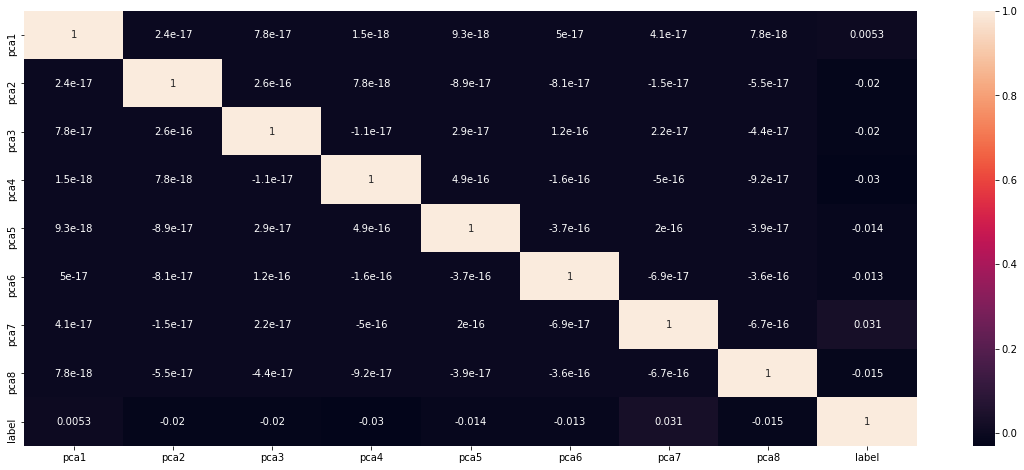

In [90]:
# Normalize for PCA:
scaler = StandardScaler()
X_trainval = scaler.fit_transform(X_trainval)
X_test = scaler.transform(X_test)

# PCA, reduce to 8 dimensions:
pca_8 = PCA(n_components=8, random_state=42)

# Fit pca_10:
X_trainval = pd.DataFrame(
    data=pca_8.fit_transform(X_trainval),
    columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8"]
)
X_test = pd.DataFrame(
    data=pca_8.transform(X_test),
    columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8"]
)

# Heatmap:
d = pd.DataFrame(X_trainval).copy()
d["label"] = y_trainval

plt.figure(figsize=(20,8))
sns.heatmap(data=d.corr(), annot=True);

Here, I plot the distribution on each of those 8 dimensions and some of them are similar to Gaussian distribution which is better than original feature distribution.

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'pca1')

Text(0, 0.5, 'Density')

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'pca2')

Text(0, 0.5, 'Density')

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'pca3')

Text(0, 0.5, 'Density')

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'pca4')

Text(0, 0.5, 'Density')

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'pca5')

Text(0, 0.5, 'Density')

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'pca6')

Text(0, 0.5, 'Density')

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'pca7')

Text(0, 0.5, 'Density')

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'pca8')

Text(0, 0.5, 'Density')

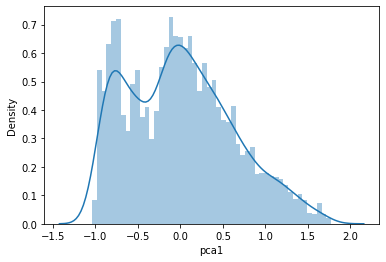

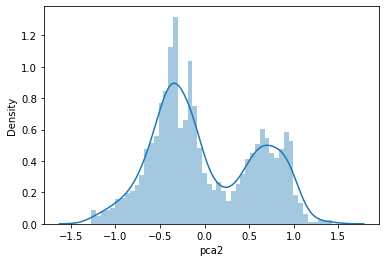

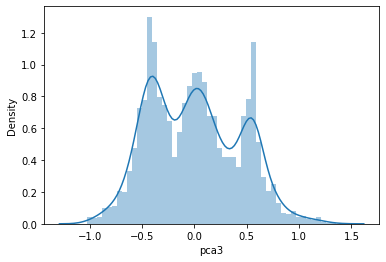

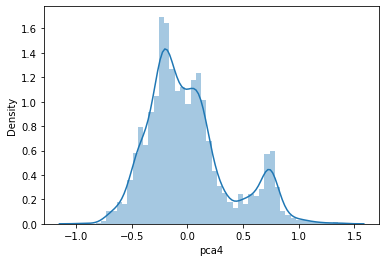

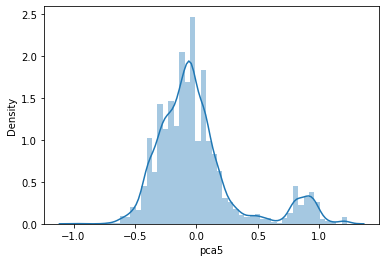

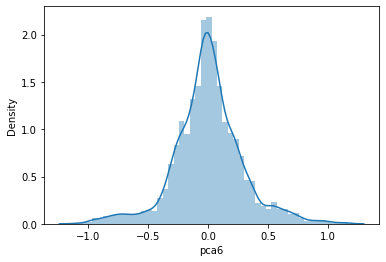

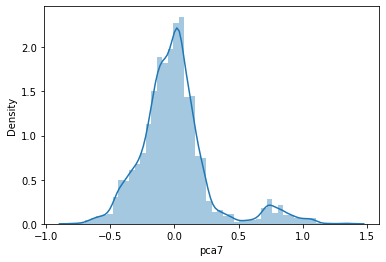

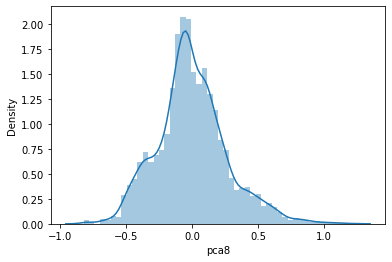

In [137]:
for col in X_trainval:
    plt.figure()
    plt.xlabel(col)
    plt.ylabel("Density")
    sns.distplot(X_trainval[col], kde=True, hist=True, bins=50, norm_hist=True);

Note that, the above standardization and PCA transformation is just for have an overview of the dataset, they are not applied when it is ready to train the model.

#### Model Building:

In [33]:
from sklearn.pipeline import Pipeline

Now, I'm going to have a pipeline for the entire process of training. First of all, StandardScaler class is created for normalize 54 features. Second, PCA reduction is applied on 54 features and reduce the dimensions to just 8. Third, I choose to use LightGBM to build this model. In order to deal with the sort of imbalanced problem, some necessary hyperparameters and the corresponding ranges are set in params variable.  

Some thoughts for controlling model to be overfitting the data:
- max_depth: no greater than 3;
- learning_rate: not too small, allow it to start from 0.1 rather than 0.001 to give it a bigger learning step;
- reg_alpha & reg_lambda: regularization terms are set to relatively larger values, greater than 0.3.

The method I use for hyperparameter tunning is Bayesian Search with 10-fold Stratified Cross Validation.

In [37]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca_8", PCA(n_components=8, random_state=42)),
    ("classifier", LGBMClassifier(objective="binary", importance_type="gain", max_depth=3, random_state=42))
])

params = {
    "classifier__learning_rate": (0.1, 0.7),      # FIRST FIXED
    "classifier__boosting_type": ("dart", "goss", "gbdt"),
    "classifier__max_depth": (1, 3),      # FIRST FIXED
    "classifier__num_leaves": (2, 50),
    "classifier__n_estimators": (10, 800),
    "classifier__subsample": (1e-3, 9e-1),
    "classifier__reg_alpha": (0.3, 0.9),      # FIRST FIXED
    "classifier__reg_lambda": (0.3, 0.9),      # FIRST FIXED
    "classifier__min_child_weight": (1e-3, 9e-1),
    "classifier__colsample_bytree": (0.01, 0.9)
}

bayes_search = BayesSearchCV(estimator=pipeline, search_spaces=params, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), n_jobs=-1, random_state=42).fit(X_trainval, y_trainval)

In [32]:
bayes_search.best_params_

OrderedDict([('classifier__boosting_type', 'dart'),
             ('classifier__colsample_bytree', 0.7378687175007389),
             ('classifier__learning_rate', 0.5447696466208164),
             ('classifier__max_depth', 2),
             ('classifier__min_child_weight', 0.521219238269318),
             ('classifier__n_estimators', 227),
             ('classifier__num_leaves', 17),
             ('classifier__reg_alpha', 0.3915567521030666),
             ('classifier__reg_lambda', 0.8363028366315117),
             ('classifier__subsample', 0.7321364405973341)])

In [213]:
bayes_search.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca_8',
                 PCA(copy=True, iterated_power='auto', n_components=8,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 LGBMClassifier(boosting_type='dart', class_weight=None,
                                colsample_bytree=0.7378687175007389,
                                importance_type='gain',
                                learning_rate=0.5447696466208164, max_depth=2,
                                min_child_samples=20,
                                min_child_weight=0.521219238269318,
                                min_split_gain=0.0, n_estimators=227, n_jobs=-1,
                                num_leaves=17, objective='binary',
                                random_state=42, reg_alpha=0.3915567521030666,
                  

The optimal model is returned with the best tunned hyperparameters. Next, I'll focus on model performance including print out classification report / confusion matrix / learning curve / ROC curve.

(0.8982630272952854, 0.8295706943223995)

(0.8731014208721215, 0.797757458869828)

array([[1458,   85],
       [ 174,  324]])

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1543
           1       0.79      0.65      0.71       498

    accuracy                           0.87      2041
   macro avg       0.84      0.80      0.82      2041
weighted avg       0.87      0.87      0.87      2041



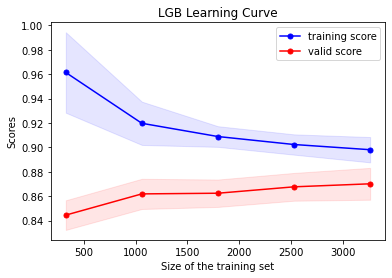

In [400]:
# Predictions:
y_pred_trainval = bayes_search.predict(X_trainval)
y_pred_test = bayes_search.predict(X_test)

# Accuracy / AUC:
accuracy_score(y_trainval, y_pred_trainval), roc_auc_score(y_trainval, y_pred_trainval)
accuracy_score(y_test, y_pred_test), roc_auc_score(y_test, y_pred_test)

# Confusion Matrix:
confusion_matrix(y_test, y_pred)

# Classification report:
print(classification_report(y_test, y_pred_test))

# Learning curve:
epx.lc("LGB", bayes_search.best_estimator_.fit(X_trainval, y_trainval), X_trainval, y_trainval, 10, trainval_level=3, valid_level=1)

In [184]:
pd.DataFrame(data={
    "Accuracy": [accuracy_score(y_test, y_pred_test)],
    "Precision": [precision_score(y_test, y_pred_test)],
    "Recall": [recall_score(y_test, y_pred_test)],
    "F1": [f1_score(y_test, y_pred_test)],
    "AUC": [roc_auc_score(y_test, y_pred_test)]
})

Accuracy  Precision    Recall        F1       AUC
0  0.873101   0.792176  0.650602  0.714443  0.797757

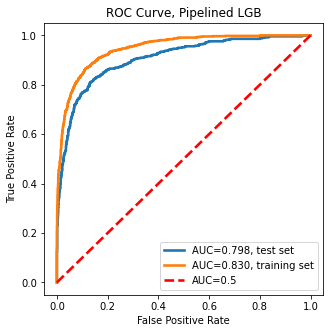

In [100]:
# ROC curve:
pred_proba = loaded_estimator["classifier"].predict_proba(loaded_estimator["pca_8"].transform(loaded_estimator["scaler"].transform(X_test)))[:,1]
tpr, fpr, _ = roc_curve(y_test, pred_proba)

pred_proba_train = loaded_estimator["classifier"].predict_proba(loaded_estimator["pca_8"].transform(loaded_estimator["scaler"].transform(X_trainval)))[:,1]
tpr_train, fpr_train, _train = roc_curve(y_trainval, pred_proba_train)

fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot()
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve, Pipelined LGB')
ax2.plot(tpr, fpr, lw=2.6)
ax2.plot(tpr_train, fpr_train, lw=2.6)
ax2.plot([0.0, 1.0],[0.0, 1.0], ls="--", lw=2.6, c="red")
ax2.legend(["AUC=0.798, test set","AUC=0.830, training set","AUC=0.5"], loc='lower right')
ax2.figure.savefig('roc_curve.png', dpi=300);

So, as we can see from the above that, the accuracy is around 87% and AUC score is around 80% on the test set. The recall score 65% is relatively low and precision is 80%, this is like the breast cancer problem, definitions for recall and precision based on my problem are:  
- TPR(sensitivity, recall):  
    - Among all dropoff people, what percentage of people is correctly identified by the model?  
- Positive Predictive Value(precision):  
    - Among all people who are predicted to drop off, what percentage of them would actually be dropping off?  
    
And, for this project, similar to breast cancer, I think recall is more important than precision and 65% recall is not too bad via training on LightGBM.

#### Feature Understanding:

Next, I'm going to use tree-based model & PCA components & SHAP value to understand feature importance.

In [45]:
# Apply normalization and PCA transformation on training set:
X_trainval_normalized = bayes_search["scaler"].transform(X_trainval)
X_trainval_reduced = bayes_search["pca_8"].transform(X_trainval_normalized)

# Apply normalization and PCA transformation on test set:
X_test_normalized = bayes_search["scaler"].transform(X_test)
X_test_reduced = bayes_search["pca_8"].transform(X_test_normalized)

# Fit training data to the model with the best hyperparameters fine-tunned via Bayesian Search:
model = bayes_search["classifier"].fit(X_trainval_reduced, y_trainval)

The .feature_importances_ method is used here to get the importance for each pca component since all original 54 features are transformed to a lower 8-d space. Based on the following dataframe, component 1 & 2 & 3 are top three important components.

In [70]:
# Feature importance via LightGBM:
importance_df = pd.DataFrame(data={
    "Importance": model.feature_importances_
}, index=["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8"])
importance_df.sort_values(by=["Importance"], ascending=False)

Importance
pca1  2863.233233
pca2  1139.290895
pca4   771.829728
pca7   517.811250
pca6   407.458663
pca8   373.016366
pca5   348.245269
pca3   102.272770

Besides, SHAP value is used addionally to understand feature importance. From the SHAP summary plot we can see that, Feature 0 / Feature 1 / Feature 3 are top three important features and they are corresponding to PCA1 / PCA2 / PCA4, which is align with the results from LightGBM's feature importance.

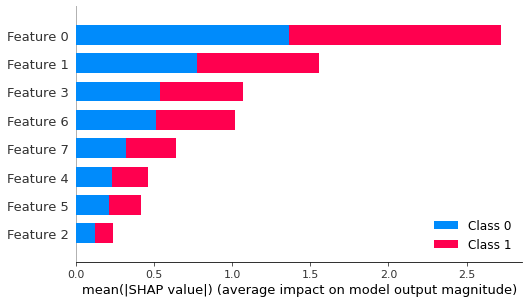

In [78]:
# Feature importance via SHAP:
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X=X_test_reduced)

shap.summary_plot(shap_values, X_test_reduced)

Note that, all features from the original dataset are used to form a combination of different weighted features in order to derive each component in reduced space (PCA). Thus, I'm going to iterate through each of 8 components to get those weights applied on each of 54 features so than I can have a clear view about the importance of 54 original features.

In [81]:
def feature_understanding(column_names, feature_number, return_all=False):
    pc_summary = pd.DataFrame(data={
        "Features": column_names,
        "PCA1_components": abs(bayes_search["pca_8"].components_[0]),
        "PCA2_components": abs(bayes_search["pca_8"].components_[1]),
        "PCA3_components": abs(bayes_search["pca_8"].components_[2]),
        "PCA4_components": abs(bayes_search["pca_8"].components_[3]),
        "PCA5_components": abs(bayes_search["pca_8"].components_[4]),
        "PCA6_components": abs(bayes_search["pca_8"].components_[5]),
        "PCA7_components": abs(bayes_search["pca_8"].components_[6]),
        "PCA8_components": abs(bayes_search["pca_8"].components_[7])
    })
    pc_summary = pc_summary.sort_values(by=[f"PCA{feature_number+1}_components"], axis=0, ascending=False)
    imp_features = list(pc_summary.Features)
    if(return_all==True):
        return pc_summary[["Features",f"PCA{feature_number+1}_components"]]
    else:
        return imp_features
    
def FI_plot(feature_number):
    fu_df = feature_understanding(column_names=X.columns, feature_number=feature_number, return_all=True)
    # fu_df = fu_df.sort_values(by=fu_df.columns[-1], axis=0, ascending=True)
    xdata = fu_df.Features.to_list()
    ydata = fu_df.iloc[:,-1].to_list()

    plt.figure(figsize=(15,5))
    plt.bar(xdata, ydata)
    plt.xticks(rotation=50, ha='right')
    plt.title(f"Feature importance, PCA_{feature_number+1}")
    plt.ylabel("PC values (importance)");

It shows from the following histgrams that:
- For PCA_1:
    - Response count is the first important (29_42_rc, 43_56_rc, 15_28_rc, 1_14_rc);
    - Rating scores and whether the patient gives a rate to the system are the second important (avg_rate, no_communication, no_rate, avg_communication, no_frequency)
    - Response rate is the third important (29_42_rr, 15_28_rr, 43_56_rr)
    - ...
- For PCA_2:
    - Session count is the first important (29_42_rc, 15_28_rc, 1_14_rc, 43_56_rc)
    - Intervention name is the second important
    - ...  

...  
- For PCA_7:
    - Age range is the first important (age_range, age_null)
    - ...  

...

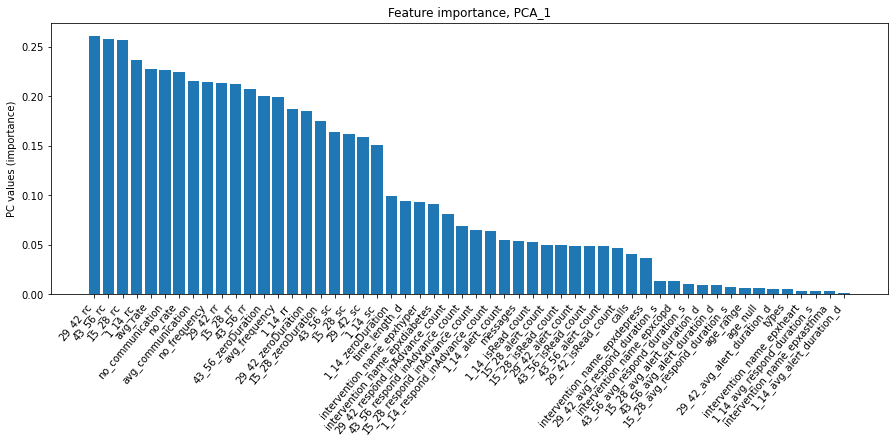

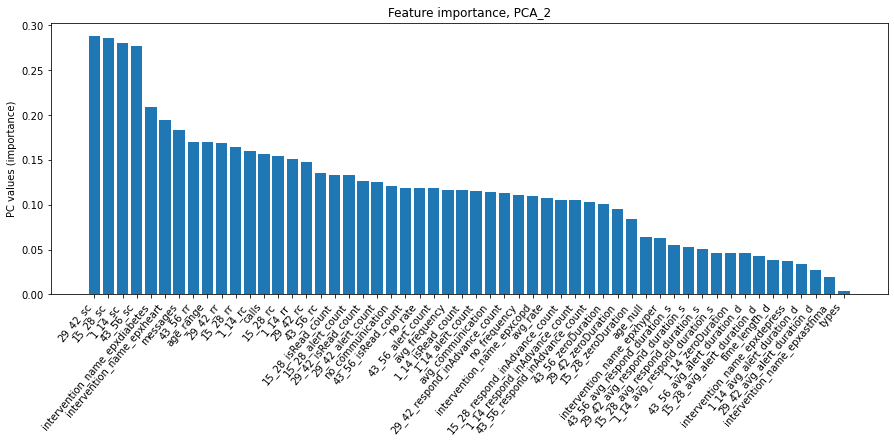

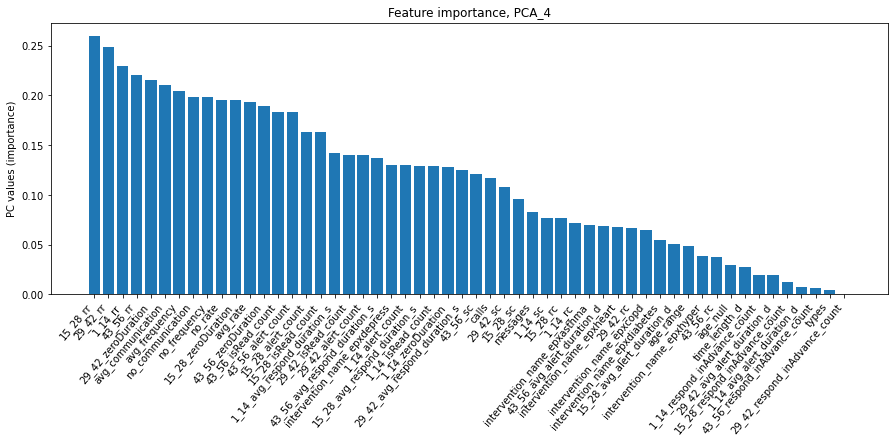

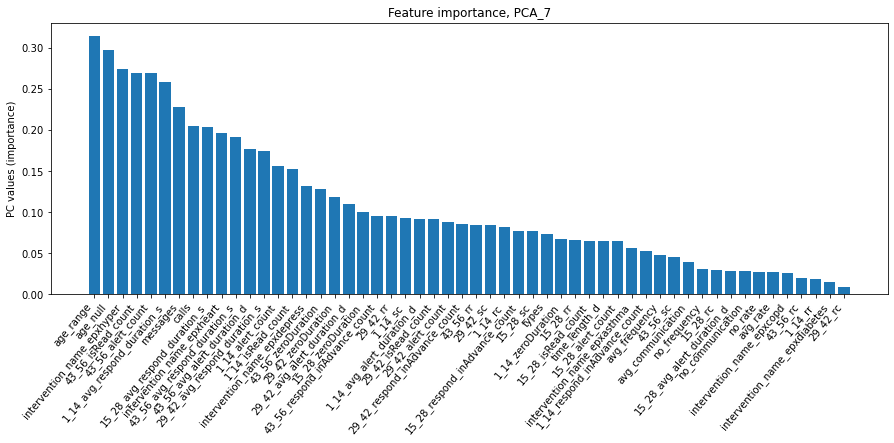

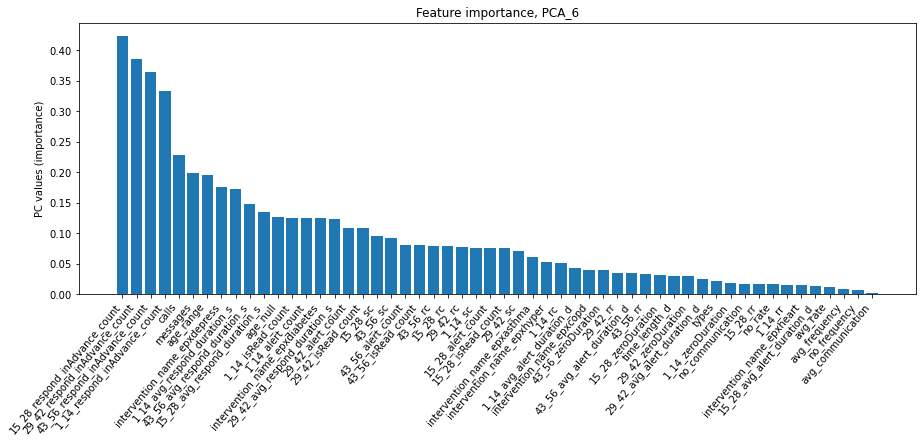

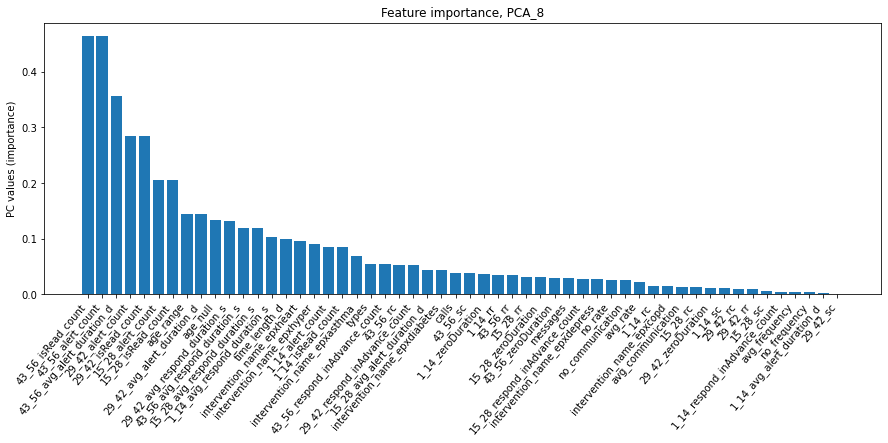

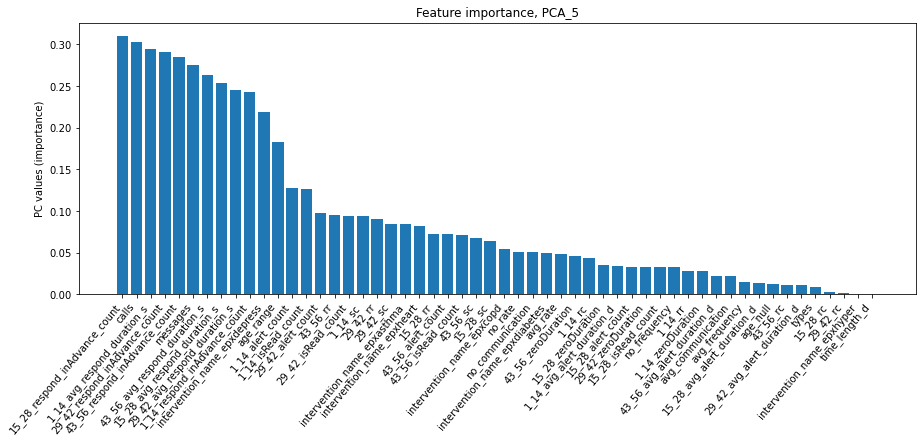

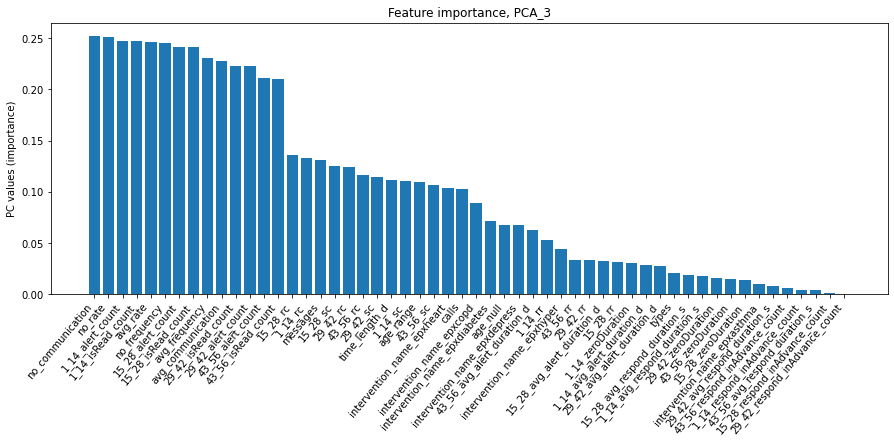

In [91]:
for f in list(map(lambda x: x-1, [1,2,4,7,6,8,5,3])):
    FI_plot(feature_number=f)

To conclude, the model has a 87% accuracy and a AUC score around 80% which is good for this not so big data and sort of imbalanced dataset.

#### Flask App - Model Deployed into Production

Not just end this here, I also deployed this model into a web app by using Flask, the result screenshots are inside /image folder.

show.gif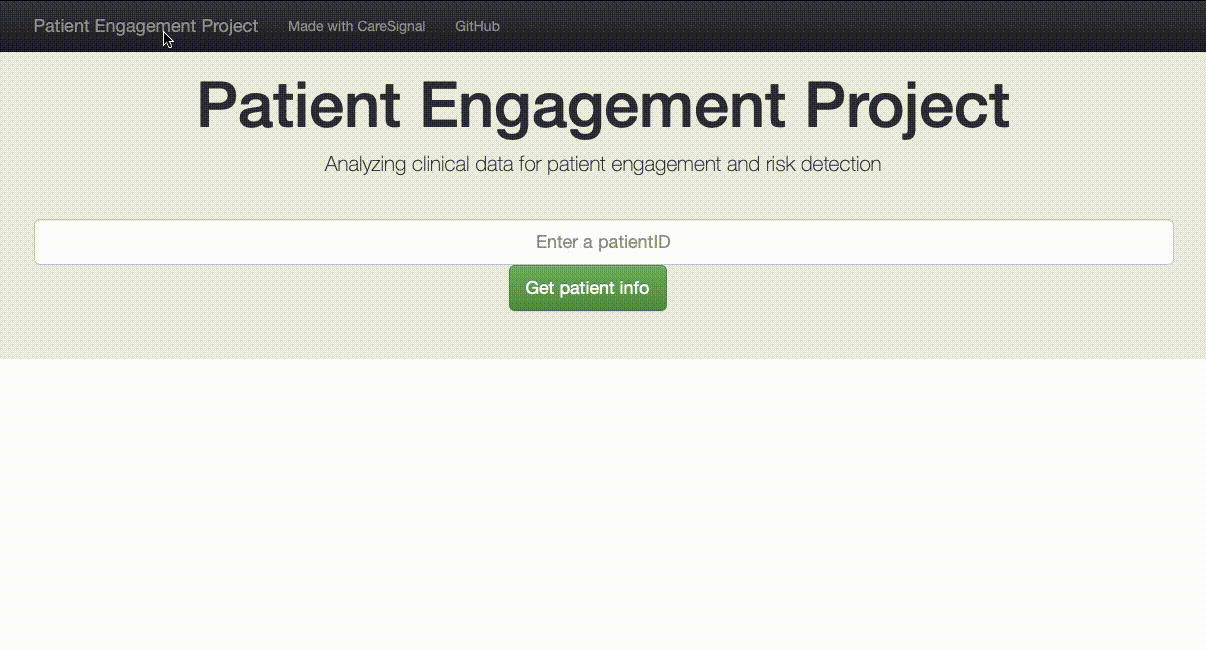

i1.png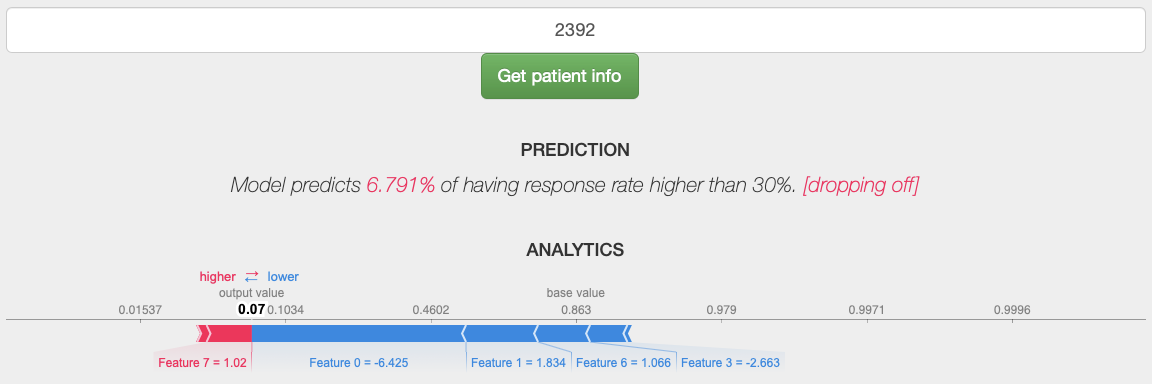

i2.png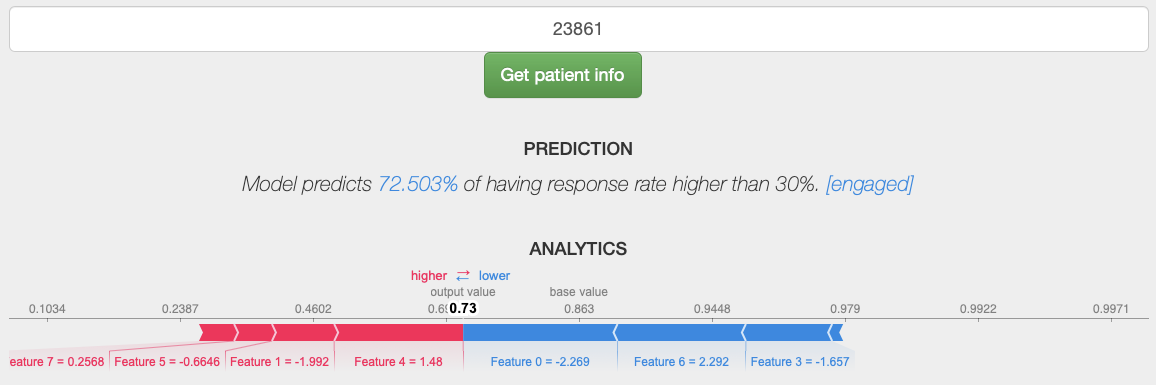